In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/var/folders/tp/qq4d22mx3sj_p39f9c6gc83w0000gn/T/ipykernel_72852/1621238366.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

# Custom functions definition:

In [2]:
def conf_matrix(y, y_pred, title, save_path):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":12})
    plt.title(title)
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels)
    ax.set_ylabel('Ground Truth Value')
    ax.set_xlabel('Predicted Value')
    plt.savefig(save_path)
    

# Loading the data

In [3]:
# Loading the data
df = pd.read_csv('a3_train.csv', header=None)
df.columns = ['Sentiment','OriginalTweet']
df_test = pd.read_csv('a3_test.tsv',sep='\t', header=None)
df_test.columns = ['Sentiment','OriginalTweet']


In [4]:
df.head()

,Sentiment,OriginalTweet
0,1,I'll only consume if I know what's inside it....
1,0,It is easier to fool a million people than it...
2,0,NATURAL IMMUNITY protected us since evolutio...
3,1,NATURAL IMMUNITY protected us since evolutio...
4,0,"Proud to have resisted. Proud of my husband, ..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48510 entries, 0 to 48509
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      48510 non-null  int64 
 1   OriginalTweet  48510 non-null  object
dtypes: int64(1), object(1)
memory usage: 758.1+ KB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

## Duplicate tweets?

In [6]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48504 entries, 0 to 48509
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      48504 non-null  int64 
 1   OriginalTweet  48504 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


# Deep Cleaning

In [8]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    # 定义一个正则表达式，匹配常见的emoji字符
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)


In [9]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))
    

In [10]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))
    

Now we can create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [11]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test


Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [12]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len
    

In [13]:
df['text_len'] = text_len

In [14]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)
    
df_test['text_len'] = text_len_test
    

In [15]:
df_test['text_len'] = text_len_test

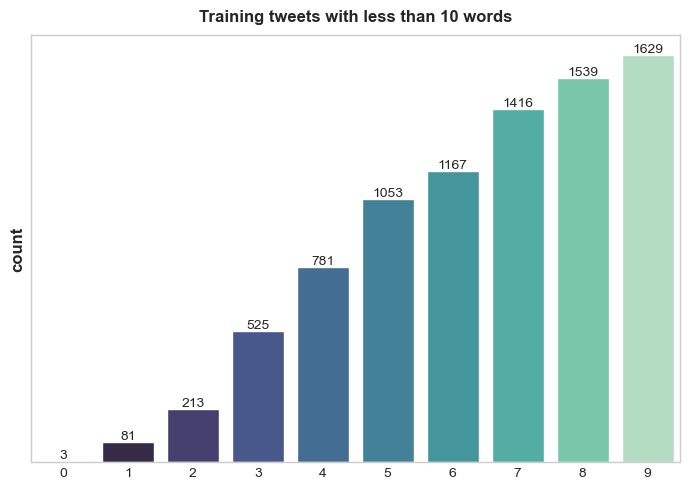

In [16]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.savefig('Training_less_10.pdf')


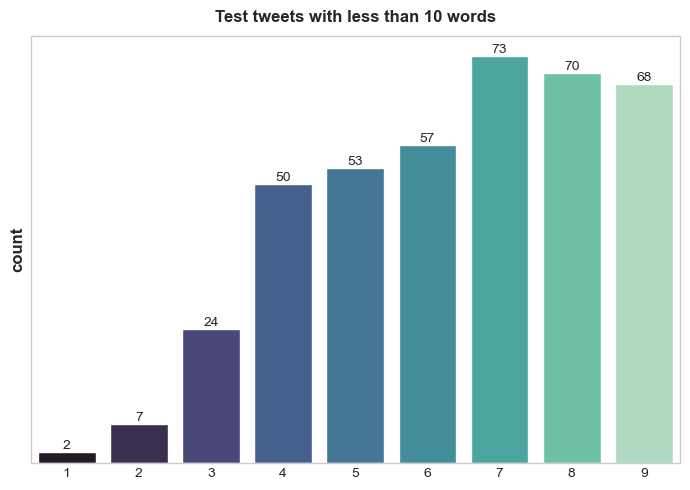

In [17]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.savefig('Test_less_10.pdf')


As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [18]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (48504, 4)
 DF TEST SHAPE: (2039, 4)


In [19]:
df = df[df['text_len'] > 4]

In [20]:
df_test = df_test[df_test['text_len'] > 4]

In [21]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (46901, 4)
 DF TEST SHAPE: (1956, 4)


## Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import the BERT tokenizer.

In [22]:
# Training data deeper cleaning
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)


In [23]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 512


In [24]:
df['token_lens'] = token_lens


In [25]:
df = df.sort_values(by='token_lens', ascending=False)
df.head()

,Sentiment,OriginalTweet,text_clean,text_len,token_lens
24013,0,Just passing this on I have carefully studied ...,just passing this on i have carefully studied ...,1230,512
21169,0,Iris Figuora: I listed all the ingredients of ...,iris figuora i listed all the ingredients of t...,502,512
10018,1,"Holy shit, the comments are full of anti-vaxxe...",holy shit the comments are full of antivaxxers...,517,512
19483,1,I've taken the Vaccine three times in the last...,ive taken the vaccine three times in the last ...,568,512
35656,0,The thing I am going to tell you is weird but ...,the thing i am going to tell you is weird but ...,1121,512


In [26]:
df['token_lens'] = token_lens
df = df.sample(frac=1).reset_index(drop=True)


## Test data deeper cleaning

In [27]:
# Test data deeper cleaning
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

df_test['token_lens'] = token_lens_test
df_test = df_test.sample(frac=1).reset_index(drop=True)



In [28]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 322


In [29]:
df_test['token_lens'] = token_lens_test

In [30]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head() 

,Sentiment,OriginalTweet,text_clean,text_len,token_lens
1266,1,Hope he got the vaccine. Either way thank you ...,hope he got the vaccine either way thank you t...,14,322
1044,0,NEVER would I put that Fauci sauce in my arm l...,never would i put that fauci sauce in my arm l...,14,248
707,0,I'll take my chances without the vaccine thank...,ill take my chances without the vaccine thank you,9,185
1620,0,"I will never take a coronavirus vaccine, there...",i will never take a coronavirus vaccine theres...,18,175
1876,0,I love how people use “anti vaxers” as a way t...,i love how people use anti vaxers as a way to ...,30,170


In [31]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Sentiment column analysis

Now we will look at the target column 'Sentiment'.

In [32]:
df['Sentiment'].value_counts()

Sentiment
0    23843
1    23058
Name: count, dtype: int64

## Train - Validation - Test split

In [33]:
# Train - Validation - Test split
X = df['text_clean'].values
y = df['Sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values



# Baseline model: Naive Bayes Classifier

Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets.

First we need to tokenize the tweets using CountVectorizer.

In [34]:
# Baseline model: Naive Bayes Classifier
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)
nb_pred = nb_clf.predict(X_test_tf)
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test,nb_pred))



	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

           0       0.82      0.85      0.83       977
           1       0.84      0.81      0.83       979

    accuracy                           0.83      1956
   macro avg       0.83      0.83      0.83      1956
weighted avg       0.83      0.83      0.83      1956



Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [35]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Now we can define the Naive Bayes Classifier model

In [36]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)
nb_pred = nb_clf.predict(X_test_tf)
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test,nb_pred))


	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

           0       0.82      0.85      0.83       977
           1       0.84      0.81      0.83       979

    accuracy                           0.83      1956
   macro avg       0.83      0.83      0.83      1956
weighted avg       0.83      0.83      0.83      1956



# BERT Sentiment Analysis

In [37]:
# BERT Sentiment Analysis
MAX_LEN=128

def tokenize(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for item in data:
        if not item:  # 检查是否为空字符串或None
            item = " "  # 将空值替换为一个空格，以避免tokenizer处理时出错
        encoded = tokenizer.encode_plus(
            item,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True  # 确保超过最大长度的输入被截断
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)


# BERT modeling

In [38]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

2024-02-18 16:23:42.928071: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-18 16:23:42.928105: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-18 16:23:42.928111: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-18 16:23:42.928163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 16:23:42.928187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform

In [39]:

def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()



    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model


In [40]:

model = create_model(bert_model, MAX_LEN)
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

Finally we can start fine tuning the BERT transformer !

In [ ]:

train_input_ids = np.array(train_input_ids)
train_attention_masks = np.array(train_attention_masks)
val_input_ids = np.array(val_input_ids)
val_attention_masks = np.array(val_attention_masks)


history_bert = model.fit(
    [train_input_ids, train_attention_masks], 
    y_train, 
    validation_data=([val_input_ids, val_attention_masks], y_valid), 
    epochs=5, 
    batch_size=32
)

# 保存模型到本地
model.save('bert-base-uncased_trained.h5')


Epoch 1/5


2024-02-18 16:23:56.772067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


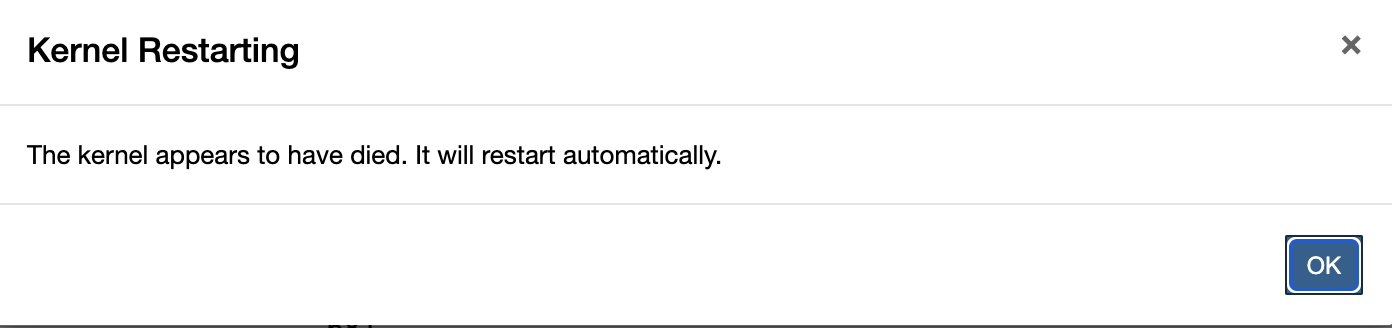
lack of computational resources, here is the system crash message.

# BERT results

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))